C:\Users\amits\AppData\Local\Temp\ipykernel_31208\416468012.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
c:\Development\investment_assistant\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0107
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 5.9484e-04
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.7172e-04
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.3488e-04
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.9238e-04
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.8974e-04
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.0180e-04
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.0625e-04
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.6182e-04
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.4342e-04
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.5189e-04
Epoch 12/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.1114e-04
Epoch 13/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.9850e-04
Epoch 14/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.1950e-04
Epoch 15/20
43/43 ━

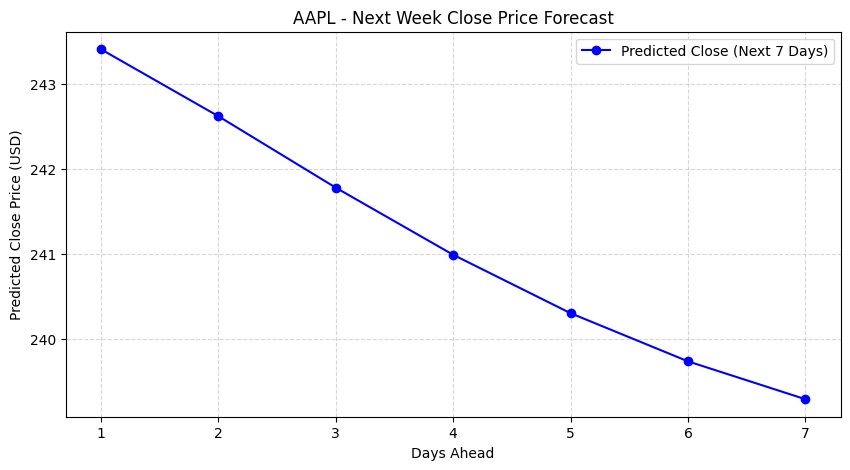

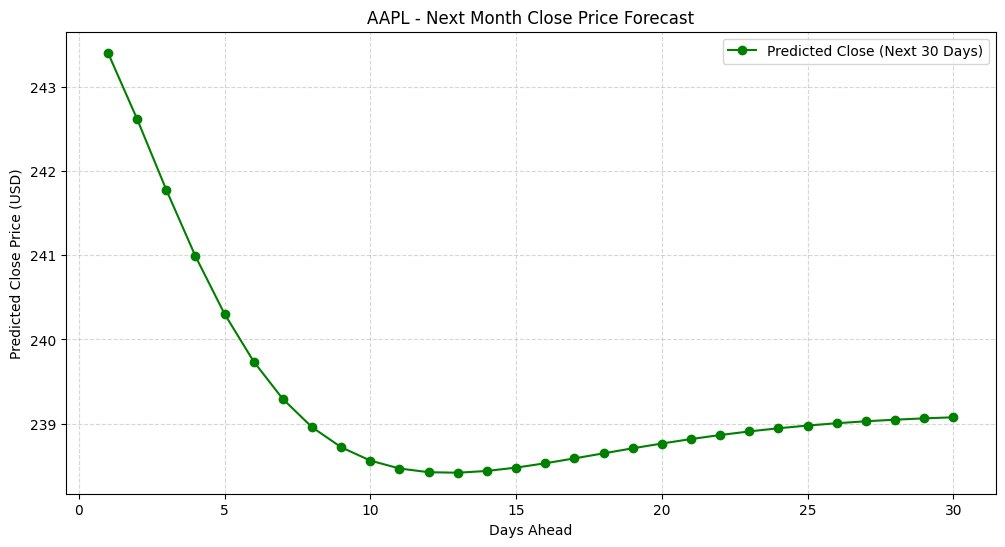

In [5]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# -----------------------------
# 1. Fetch Historical Data
# -----------------------------
symbol = "AAPL"
data = yf.download(symbol, start="2018-01-01", end="2025-01-01")

# Use all 6 features
features = ['Open', 'High', 'Low', 'Close', 'Close', 'Volume']
dataset = data[features]

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# -----------------------------
# 2. Train/Test Split
# -----------------------------
training_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]

# Function to create dataset (X = past 'time_step' days, y = next day's Close)
def create_dataset_multivariate(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step)])
        y.append(dataset[i + time_step, 3])  # index 3 = Close
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset_multivariate(train_data, time_step)
X_test, y_test = create_dataset_multivariate(test_data, time_step)

# -----------------------------
# 3. Build LSTM Model
# -----------------------------
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

# -----------------------------
# 4. Evaluate on Test Data
# -----------------------------
y_pred = model.predict(X_test)

dummy_pred = np.zeros((len(y_pred), scaled_data.shape[1]))
dummy_pred[:, 3] = y_pred.flatten()

dummy_actual = np.zeros((len(y_test), scaled_data.shape[1]))
dummy_actual[:, 3] = y_test.flatten()

y_predicted = scaler.inverse_transform(dummy_pred)[:, 3]
y_actual = scaler.inverse_transform(dummy_actual)[:, 3]

mse = mean_squared_error(y_actual, y_predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_predicted)

print("\n📊 Model Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

## -----------------------------
# 5. Future Predictions
# -----------------------------
def predict_future_days_multivariate(model, last_sequence, days_ahead=7):
    current_seq = last_sequence.copy()
    future_predictions = []

    for _ in range(days_ahead):
        X_future = current_seq.reshape(1, time_step, scaled_data.shape[1])
        next_pred_scaled = model.predict(X_future, verbose=0)[0, 0]
        future_predictions.append(next_pred_scaled)

        # Create new input row (replace Close with predicted value)
        new_row = current_seq[-1].copy()
        new_row[3] = next_pred_scaled
        current_seq = np.vstack((current_seq[1:], new_row))

    # Inverse scale (only Close)
    dummy_future = np.zeros((len(future_predictions), scaled_data.shape[1]))
    dummy_future[:, 3] = future_predictions
    future_prices = scaler.inverse_transform(dummy_future)[:, 3]

    return future_prices

# Get last 60 days for forecasting
last_60_days = scaled_data[-time_step:]

# Predict next day, week, and month
future_1d = predict_future_days_multivariate(model, last_60_days, days_ahead=1)
future_7d = predict_future_days_multivariate(model, last_60_days, days_ahead=7)
future_30d = predict_future_days_multivariate(model, last_60_days, days_ahead=30)

# -----------------------------
# Print Predictions
# -----------------------------
print("\n📅 Predicted Next Day Close Price:", round(future_1d[-1], 2))
print("\n📅 Predicted Next 7 Days Close Prices:")
for i, p in enumerate(future_7d, 1):
    print(f"Day {i}: {round(p, 2)}")

print("\n📅 Predicted Next 30 Days Close Prices:")
for i, p in enumerate(future_30d, 1):
    print(f"Day {i}: {round(p, 2)}")

# -----------------------------
# 6. Visualization – Two Plots
# -----------------------------

# Plot 1: Next Week Forecast
plt.figure(figsize=(10,5))
plt.plot(range(1, 8), future_7d, marker='o', color='blue', label="Predicted Close (Next 7 Days)")
plt.title(f"{symbol} - Next Week Close Price Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Close Price (USD)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Plot 2: Next Month Forecast
plt.figure(figsize=(12,6))
plt.plot(range(1, 31), future_30d, marker='o', color='green', label="Predicted Close (Next 30 Days)")
plt.title(f"{symbol} - Next Month Close Price Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Close Price (USD)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


/tmp/ipython-input-64102161.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Epoch 1/20



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0154
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 6.0447e-04
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 4.3542e-04
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 5.2444e-04
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 4.3099e-04
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 4.6203e-04
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 4.3406e-04
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 3.9407e-04
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 4.3848e-04
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 3.6020e-04
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 3.2401e-04
Epoch 12/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 3.5591e-04
Epoch 13/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 3.4180e-04
Epoch 14/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 3.0143e-04
Epoch 15/20
43/43 ━━━━━━━━━━━━

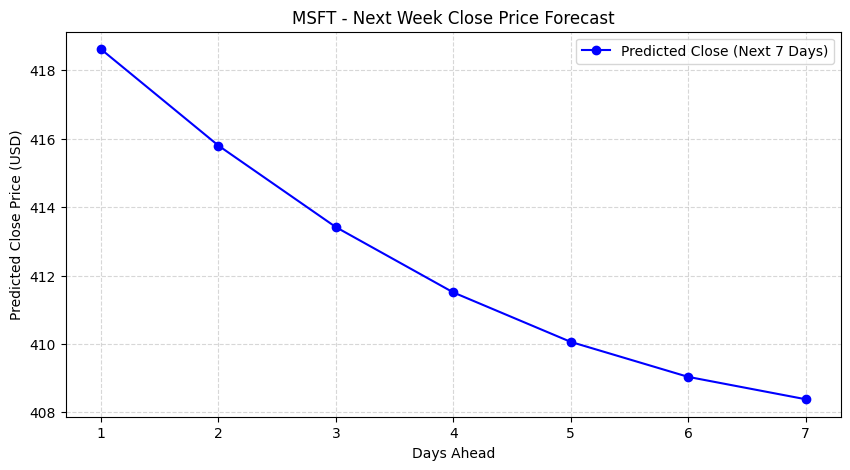

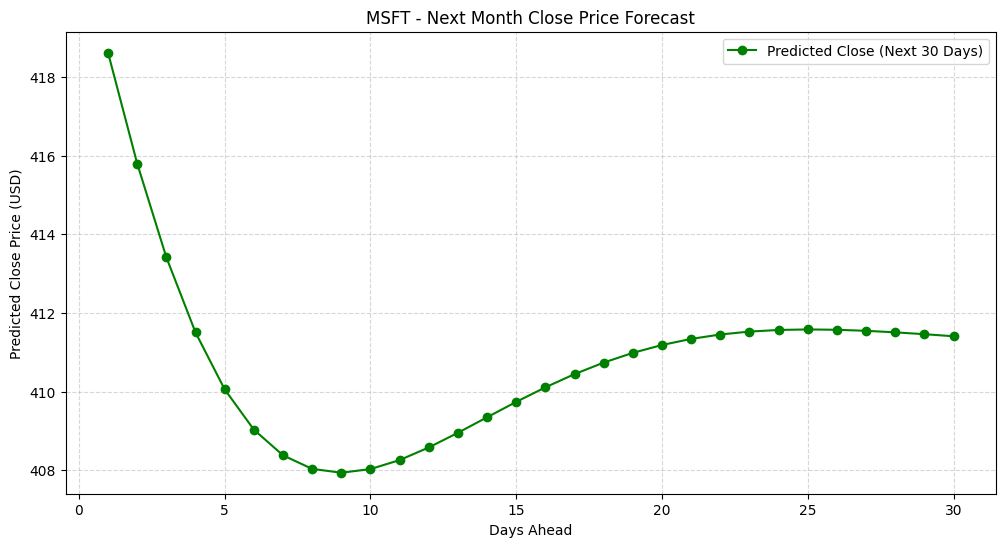

In [2]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# -----------------------------
# 1. Fetch Historical Data
# -----------------------------
symbol = "MSFT"
data = yf.download(symbol, start="2018-01-01", end="2025-01-01")

# Use all 6 features
features = ['Open', 'High', 'Low', 'Close', 'Close', 'Volume']
dataset = data[features]

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# -----------------------------
# 2. Train/Test Split
# -----------------------------
training_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]

# Function to create dataset (X = past 'time_step' days, y = next day's Close)
def create_dataset_multivariate(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step)])
        y.append(dataset[i + time_step, 3])  # index 3 = Close
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset_multivariate(train_data, time_step)
X_test, y_test = create_dataset_multivariate(test_data, time_step)

# -----------------------------
# 3. Build LSTM Model
# -----------------------------
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

# -----------------------------
# 4. Evaluate on Test Data
# -----------------------------
y_pred = model.predict(X_test)

dummy_pred = np.zeros((len(y_pred), scaled_data.shape[1]))
dummy_pred[:, 3] = y_pred.flatten()

dummy_actual = np.zeros((len(y_test), scaled_data.shape[1]))
dummy_actual[:, 3] = y_test.flatten()

y_predicted = scaler.inverse_transform(dummy_pred)[:, 3]
y_actual = scaler.inverse_transform(dummy_actual)[:, 3]

mse = mean_squared_error(y_actual, y_predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_predicted)

print("\n📊 Model Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

## -----------------------------
# 5. Future Predictions
# -----------------------------
def predict_future_days_multivariate(model, last_sequence, days_ahead=7):
    current_seq = last_sequence.copy()
    future_predictions = []

    for _ in range(days_ahead):
        X_future = current_seq.reshape(1, time_step, scaled_data.shape[1])
        next_pred_scaled = model.predict(X_future, verbose=0)[0, 0]
        future_predictions.append(next_pred_scaled)

        # Create new input row (replace Close with predicted value)
        new_row = current_seq[-1].copy()
        new_row[3] = next_pred_scaled
        current_seq = np.vstack((current_seq[1:], new_row))

    # Inverse scale (only Close)
    dummy_future = np.zeros((len(future_predictions), scaled_data.shape[1]))
    dummy_future[:, 3] = future_predictions
    future_prices = scaler.inverse_transform(dummy_future)[:, 3]

    return future_prices

# Get last 60 days for forecasting
last_60_days = scaled_data[-time_step:]

# Predict next day, week, and month
future_1d = predict_future_days_multivariate(model, last_60_days, days_ahead=1)
future_7d = predict_future_days_multivariate(model, last_60_days, days_ahead=7)
future_30d = predict_future_days_multivariate(model, last_60_days, days_ahead=30)

# -----------------------------
# Print Predictions
# -----------------------------
print("\n📅 Predicted Next Day Close Price:", round(future_1d[-1], 2))
print("\n📅 Predicted Next 7 Days Close Prices:")
for i, p in enumerate(future_7d, 1):
    print(f"Day {i}: {round(p, 2)}")

print("\n📅 Predicted Next 30 Days Close Prices:")
for i, p in enumerate(future_30d, 1):
    print(f"Day {i}: {round(p, 2)}")

# -----------------------------
# 6. Visualization – Two Plots
# -----------------------------

# Plot 1: Next Week Forecast
plt.figure(figsize=(10,5))
plt.plot(range(1, 8), future_7d, marker='o', color='blue', label="Predicted Close (Next 7 Days)")
plt.title(f"{symbol} - Next Week Close Price Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Close Price (USD)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Plot 2: Next Month Forecast
plt.figure(figsize=(12,6))
plt.plot(range(1, 31), future_30d, marker='o', color='green', label="Predicted Close (Next 30 Days)")
plt.title(f"{symbol} - Next Month Close Price Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Close Price (USD)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


/tmp/ipython-input-1348912090.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start="2018-01-01", end="2025-10-01")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0274
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0011
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 9.0746e-04
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 8.4344e-04
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 7.9279e-04
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 7.4733e-04
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 7.4929e-04
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 6.6602e-04
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 6.3663e-04
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 6.5290e-04
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 5.7566e-04
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 6.3858e-04
Epoch 13/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 6.0746e-04
Epoch 14/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 5.2057e-04
Epoch 15/20
47/47 ━━━━

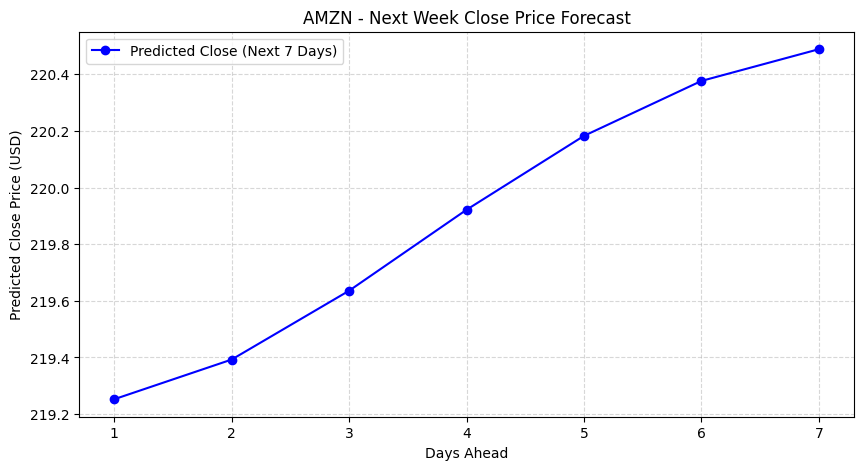

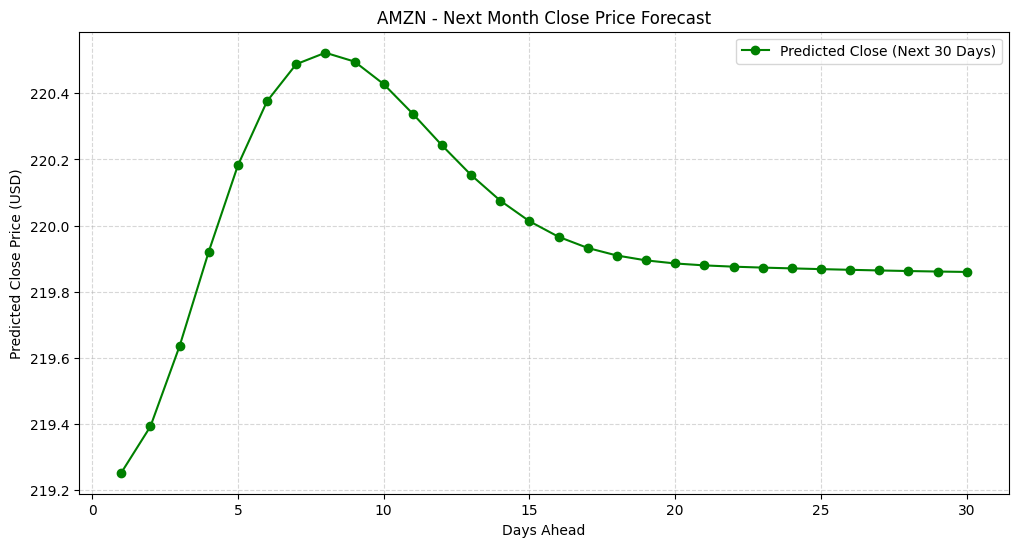

In [3]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# -----------------------------
# 1. Fetch Historical Data
# -----------------------------
symbol = "AMZN"
data = yf.download(symbol, start="2018-01-01", end="2025-10-01")

# Use all 6 features
features = ['Open', 'High', 'Low', 'Close', 'Close', 'Volume']
dataset = data[features]

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# -----------------------------
# 2. Train/Test Split
# -----------------------------
training_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]

# Function to create dataset (X = past 'time_step' days, y = next day's Close)
def create_dataset_multivariate(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step)])
        y.append(dataset[i + time_step, 3])  # index 3 = Close
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset_multivariate(train_data, time_step)
X_test, y_test = create_dataset_multivariate(test_data, time_step)

# -----------------------------
# 3. Build LSTM Model
# -----------------------------
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

# -----------------------------
# 4. Evaluate on Test Data
# -----------------------------
y_pred = model.predict(X_test)

dummy_pred = np.zeros((len(y_pred), scaled_data.shape[1]))
dummy_pred[:, 3] = y_pred.flatten()

dummy_actual = np.zeros((len(y_test), scaled_data.shape[1]))
dummy_actual[:, 3] = y_test.flatten()

y_predicted = scaler.inverse_transform(dummy_pred)[:, 3]
y_actual = scaler.inverse_transform(dummy_actual)[:, 3]

mse = mean_squared_error(y_actual, y_predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_predicted)

print("\n📊 Model Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

## -----------------------------
# 5. Future Predictions
# -----------------------------
def predict_future_days_multivariate(model, last_sequence, days_ahead=7):
    current_seq = last_sequence.copy()
    future_predictions = []

    for _ in range(days_ahead):
        X_future = current_seq.reshape(1, time_step, scaled_data.shape[1])
        next_pred_scaled = model.predict(X_future, verbose=0)[0, 0]
        future_predictions.append(next_pred_scaled)

        # Create new input row (replace Close with predicted value)
        new_row = current_seq[-1].copy()
        new_row[3] = next_pred_scaled
        current_seq = np.vstack((current_seq[1:], new_row))

    # Inverse scale (only Close)
    dummy_future = np.zeros((len(future_predictions), scaled_data.shape[1]))
    dummy_future[:, 3] = future_predictions
    future_prices = scaler.inverse_transform(dummy_future)[:, 3]

    return future_prices

# Get last 60 days for forecasting
last_60_days = scaled_data[-time_step:]

# Predict next day, week, and month
future_1d = predict_future_days_multivariate(model, last_60_days, days_ahead=1)
future_7d = predict_future_days_multivariate(model, last_60_days, days_ahead=7)
future_30d = predict_future_days_multivariate(model, last_60_days, days_ahead=30)

# -----------------------------
# Print Predictions
# -----------------------------
print("\n📅 Predicted Next Day Close Price:", round(future_1d[-1], 2))
print("\n📅 Predicted Next 7 Days Close Prices:")
for i, p in enumerate(future_7d, 1):
    print(f"Day {i}: {round(p, 2)}")

print("\n📅 Predicted Next 30 Days Close Prices:")
for i, p in enumerate(future_30d, 1):
    print(f"Day {i}: {round(p, 2)}")

# -----------------------------
# 6. Visualization – Two Plots
# -----------------------------

# Plot 1: Next Week Forecast
plt.figure(figsize=(10,5))
plt.plot(range(1, 8), future_7d, marker='o', color='blue', label="Predicted Close (Next 7 Days)")
plt.title(f"{symbol} - Next Week Close Price Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Close Price (USD)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Plot 2: Next Month Forecast
plt.figure(figsize=(12,6))
plt.plot(range(1, 31), future_30d, marker='o', color='green', label="Predicted Close (Next 30 Days)")
plt.title(f"{symbol} - Next Month Close Price Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Close Price (USD)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()
